In [57]:
#importing all libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [59]:
#loading tha dataset
df = pd.read_csv("iot_traffic_data.csv")

# displaying shape and some few rows
print("Original dataset shape:", df.shape)
print("Column names:", df.columns.tolist())
df.head()



Original dataset shape: (8288, 12)
Column names: ['Timestamp', 'Device_Type', 'Src_IP', 'Dst_IP', 'Src_Port', 'Dst_Port', 'Protocol', 'Packet_Size', 'Flags', 'Payload', 'Activity', 'Label']


,Timestamp,Device_Type,Src_IP,Dst_IP,Src_Port,Dst_Port,Protocol,Packet_Size,Flags,Payload,Activity,Label
0,2024-05-26 21:25:24.178477,Smart Lock,75.191.213.34,91.126.134.188,64927,5866,TCP,776,FIN,178,sending data,1
1,2024-05-27 22:04:45.178477,Smart Lock,159.86.87.106,64.202.179.201,22858,61498,UDP,1341,RST,1238,sending data,0
2,2024-05-27 23:15:47.178477,Smart Lock,238.245.183.93,81.57.157.140,21042,4709,TCP,1428,ACK,1273,receiving data,1
3,2024-05-27 06:07:05.178477,Smart Lock,70.142.34.152,183.38.176.222,3799,31702,TCP,227,RST,196,sending data,1
4,2024-05-26 21:31:29.178477,Smart Lock,52.57.168.121,93.38.226.123,23985,29578,TCP,531,NaN,1160,receiving data,1


In [60]:
# Rename label column with target
df.rename(columns={'Label': 'target'}, inplace=True)


In [62]:
  #Replace text data into numeric

df['target'] = df['target'].replace({
    'Normal': 0,
    'Anomaly': 1,
    'BENIGN': 0,
    'MALICIOUS': 1
})


In [63]:
# take only 0 and 1
df = df[df['target'].isin([0, 1])]

   #split the data 0 and 1 class
class_0 = df[df['target'] == 0]
class_1 = df[df['target'] == 1]


In [64]:
 # taking equal data from classes
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
]).sample(frac=1, random_state=42)

# Printing class distribution
print("Balanced class distribution:\n", df_balanced['target'].value_counts())

Balanced class distribution:
 target
0    4038
1    4038
Name: count, dtype: int64


In [65]:
#seeparate features and targets
X = df_balanced.drop('target', axis=1)
y = df_balanced['target']

In [66]:
# taking numeric features
X_numeric = X.select_dtypes(include=['int64', 'float64'])


In [67]:
# Drop rows which has missing values in features
X_numeric = X_numeric.dropna()
y = y.loc[X_numeric.index]

In [68]:
#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

In [69]:
# Reduce dimensions by applying pca
n_components = min(2, X_scaled.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA output shape:", X_pca.shape)


PCA output shape: (8076, 2)


In [70]:
# spliting target and features after applying PCA

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Showing class distribution
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


y_train distribution:
 target
1    3230
0    3230
Name: count, dtype: int64
y_test distribution:
 target
0    808
1    808
Name: count, dtype: int64


In [71]:
 # traning a support vector machine model with a linear kernel
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# predicting using  the trained model
y_pred = svm_model.predict(X_test)

# Evaluate model performance
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" Accuracy Score:", accuracy_score(y_test, y_pred))


 Confusion Matrix:
 [[410 398]
 [361 447]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52       808
           1       0.53      0.55      0.54       808

    accuracy                           0.53      1616
   macro avg       0.53      0.53      0.53      1616
weighted avg       0.53      0.53      0.53      1616

 Accuracy Score: 0.5303217821782178


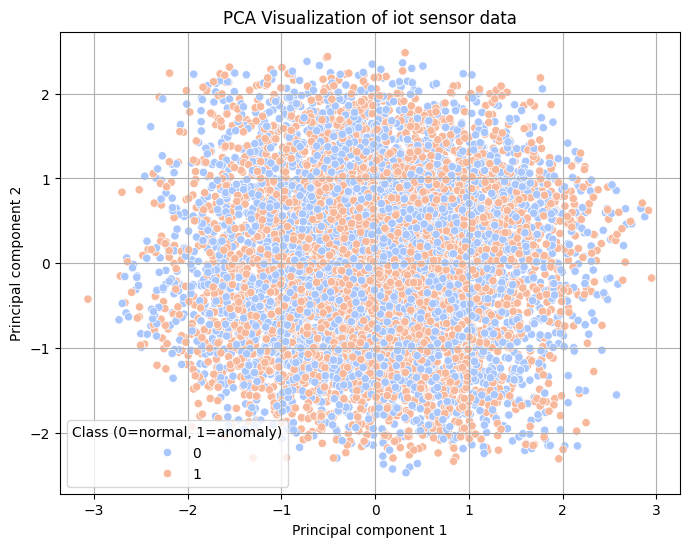

In [72]:
#  plot graph of PCA-reduced features with class coloring
if X_pca.shape[1] == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
    plt.title("PCA Visualization of iot sensor data")
    plt.xlabel("Principal component 1")
    plt.ylabel("Principal component 2")
    plt.legend(title='Class (0=normal, 1=anomaly)')
    plt.grid(True)
    plt.show()
else:
    print("PCA visualization skipped ")
